# Extract text from PDF

## Import libraries

In [1]:
# pip install PyPDF2
# pip install textract
# pip install nltk
# pip install wordcloud
# pip install plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import PyPDF2 
import textract
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
import collections
from os import path
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import plotly.graph_objects as go

## Extract text from PDF

📝 First, we create a function to extract all the word from the PDF file using PyPDF2.

In [3]:
def read_pdf(file):
    reader = PyPDF2.PdfFileReader(file)
    num_pages = reader.numPages
    count = 0
    text = ""
    num_pages
    #The while loop will read each page.
    while count < num_pages:
        pageObj = reader.getPage(count)
        count +=1
        text += pageObj.extractText()
    #This if statement exists to check if the above library returned words. It's done because PyPDF2 cannot read scanned files.
    if text != "":
        text = text
    #If the above returns as False, we run the OCR library textract to #convert scanned/image based PDF files into text.
    else:
        text = textract.process(file, method='tesseract', language='eng')

    return text

📝 The text from the PDF will be tokenized and the list of word are cleaned in two ways.

The first one is by considering **all** the words from the text.

In [4]:
def tokenize_without_stop(text):
    #The word_tokenize() function will break our text phrases into individual words.
    tokens = word_tokenize(text)
    # put all words in lower case
    lower_text = [x.lower() for x in tokens]
    #remove the numbers
    no_integers = [x for x in lower_text if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
    #We create a list comprehension that only returns a list of words that are NOT IN stop_words and NOT IN punctuations.
    keywords_ws = [word for word in no_integers if not word in string.punctuation]
    return keywords_ws

📝 The second one by **removing the most common english words and some archaic most common words**.

In [114]:
def tokenize_word_text(text):
    #The word_tokenize() function will break our text phrases into individual words.
    tokens = word_tokenize(text)
    # put all words in lower case
    lower_text = [x.lower() for x in tokens]
    #remove the numbers
    no_integers = [x for x in lower_text if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
    #We initialize the stopwords variable, which is a list of common english words
    stop_words = stopwords.words('english')
    #list of archaic english words and some non requiered specific punctuations
    old_english = ["thy", "thou", "thee", "shall", "shalt", "ye", "thyne", "'s", "didst", "hast", "hath", "unto", "¶", "’", "''", "``"]

    #We create a list comprehension that only returns a list of words that are NOT IN stop_words and NOT IN punctuations.
    keywords = [word for word in no_integers if not word in stop_words and not word in string.punctuation and not word in old_english]
    return keywords

📝 With this cleaned list of words, we'll count the frequency of each word.

Two functions can be used:

1️⃣ Number 1

In [6]:
def word_count_full(words):
    counts = {}
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

2️⃣ A simple version of this function is by using Counter from collections

In [7]:
def word_count(words):
    return dict(Counter(words))

📝 We can display the values in a pandas dataframe

In [8]:
def new_file(file_dict):
    df_file = pd.DataFrame.from_dict(file_dict, orient = 'index')
    df_file_1 = df_file.sort_values(0, ascending = False).reset_index().rename(columns={'index':'word', 0:'count'})
    df_file_new = df_file_1.groupby('word', as_index=False).sum().sort_values('count', ascending= False)

    return df_file_new

📝 Or directly vizualise them with a wordcloud

In [9]:
def word_cloud(file_dict, count):
    plt.figure(figsize=(12,9))
    wc = WordCloud(width = 1000, height = 500, background_color="black",
                   contour_width=3, max_words=count, colormap = "Blues")
    # generate word cloud
    wc.generate_from_frequencies(file_dict)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt.show()

📝 This function displays a wordcloud and a barplot

In [10]:
def wordcloud_bar(file_dict, count, x1, y1, title, fig_title):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    wc = WordCloud(width = 1500, height = 2000, background_color="black",
                   contour_width=3, max_words=count, colormap = "Blues").generate_from_frequencies(file_dict)
    axs[0].imshow(wc, interpolation="bilinear")
    axs[0].axis("off")
    s = sns.barplot(y=x1, x=y1,palette="Blues", edgecolor = "steelblue", lw=0.5, ax=axs[1])
    plt.xticks(rotation=90, size = 8)
    plt.yticks(rotation=0, size = 8)
    axs[1].set_title(title)
    for i in axs[1].containers:
        axs[1].bar_label(i,)
    plt.savefig(fig_title)
    return plt.plot()

# Data Analysis of the Douay–Rheims Bible

### Full text analysis
📝Let us analyse all the text

In [11]:
file_name= '../raw_data/Bible.pdf'
file = open(file_name,'rb')
text = read_pdf(file)

In [12]:
keywords_ws = tokenize_without_stop(text)
file_dict_ws = word_count(keywords_ws)
df_file_new_ws = new_file(file_dict_ws)

In [13]:
df_file_new_ws.describe()

,count
count,25423.000000
mean,35.687566
std,670.287118
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,69224.000000


In [14]:
df_file_new_ws["count"].sum()

907285

📝 Above 9000 the points are more rare

<AxesSubplot: xlabel='count'>

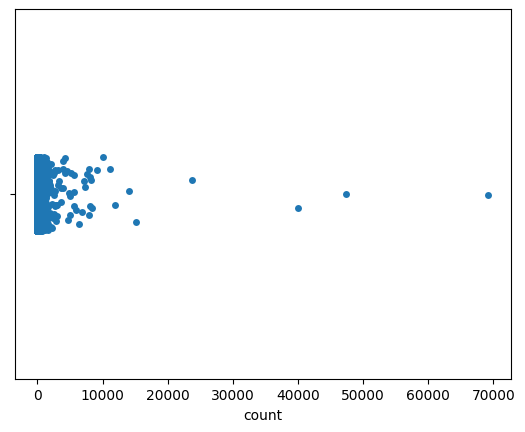

In [15]:
sns.stripplot(df_file_new_ws, x="count")

In [265]:
df_up9000_ws = df_file_new_ws.query("count >9000")
df_up9000_ws.head()

,word,count
23083,the,69224
7107,and,47317
18034,of,39945
23654,to,23693
14743,in,15124


In [17]:
df_up9000_ws.shape

(10, 2)

📝 We visualize the data using a wordcloud and a barplot

[]

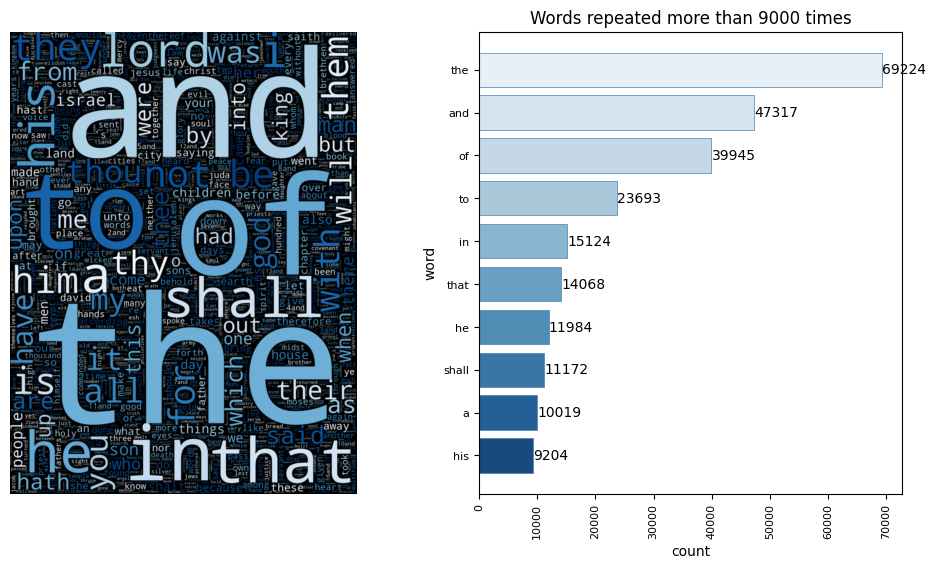

In [18]:
wordcloud_bar(file_dict_ws, 2000, df_up9000_ws["word"], df_up9000_ws["count"], "Words repeated more than 9000 times", "../raw_data/total_words.jpg")

📝This function filter words from a list, display them as a graph and save the figure as .jpg

In [19]:
def plot_word(df,list_words, title, position1, title_x, title_y, main_title):
    fig, axs = plt.subplots()
    s = sns.barplot(data= df[df["word"].isin(list_words)], x="word", y="count", palette = "Blues", edgecolor ="steelblue", alpha=0.4,)
    plt.xticks(rotation=90)
    s.set_xlabel(title_x)
    s.set_ylabel(title_y, size=14)
    s.axes.xaxis.set_ticks_position(position1)
    plt.title(title, size=20)
    for i in axs.containers:
        axs.bar_label(i,)
    plt.savefig(main_title, bbox_inches='tight')
    return plt.plot()

In [20]:
list_men_pronouns = ["he", "his", "him","son", "man", "sons","jesus", "father", "son"]
list_women_pronouns = ["she", "her","daughter","woman","daughters", "mary", "magdalene", "mother"]

[]

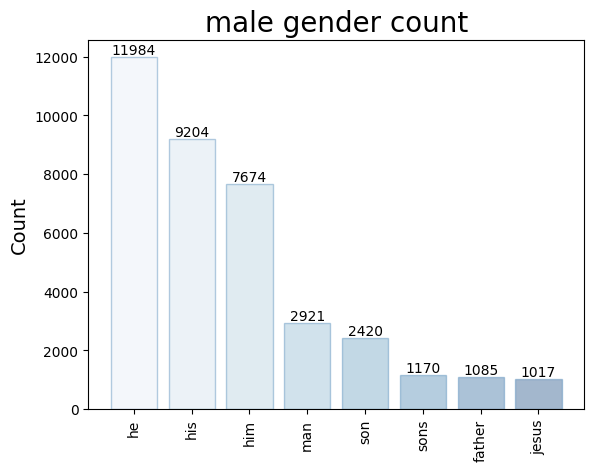

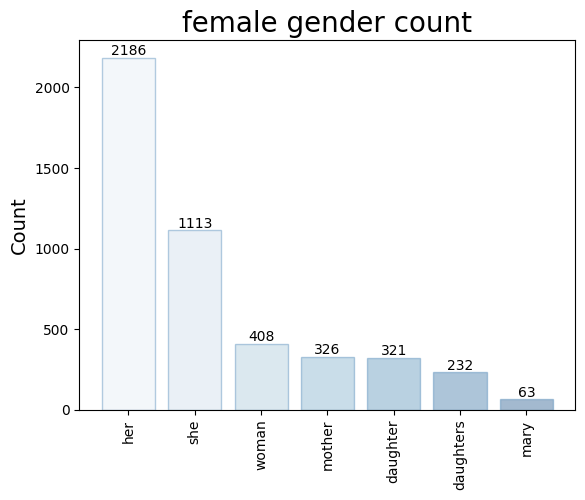

In [267]:
plot_word(df_file_new_ws,list_men_pronouns, "male gender count", "bottom", None, "Count", "../raw_data/gender_counts_men.jpg")
plot_word(df_file_new_ws, list_women_pronouns, "female gender count","bottom", None, "Count", "../raw_data/gender_counts_women.jpg")

### Data without the most common english words

In [22]:
keywords = tokenize_word_text(text)
file_dict = word_count(keywords)
df_file_new = new_file(file_dict)

In [23]:
df_file_new_ws[df_file_new_ws["word"].isin(stopwords.words('english'))]

,word,count
23083,the,69224
7107,and,47317
18034,of,39945
23654,to,23693
14743,in,15124
...,...,...
8215,below,4
25138,won,4
14171,hers,3
20590,s,2


📝 Sum of removed words

In [24]:
df_file_new_ws["count"].sum()-df_file_new["count"].sum()

494360

📝 New word count

In [25]:
df_file_new["count"].sum()

412925

📝 Above 2000 there are a bit less words

<AxesSubplot: xlabel='count'>

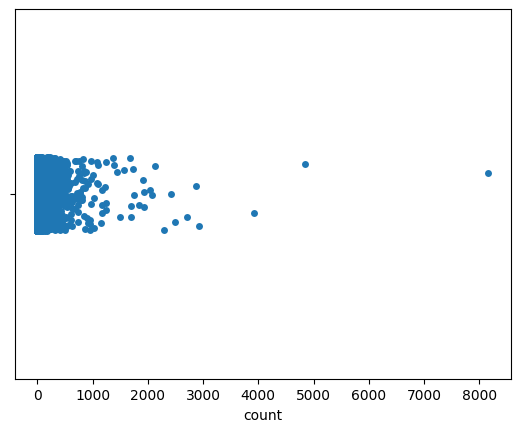

In [26]:
sns.stripplot(df_file_new, x="count")

In [264]:
df_up2000 = df_file_new.query("count >2000").reset_index()
df_up2000.head()

,index,word,count
0,16244,lord,8165
1,13327,god,4853
2,20569,said,3929
3,16551,man,2921
4,24171,upon,2876


📝numbers of words with occurancy more than 2000

In [28]:
df_up2000.shape

(12, 3)

📝 Let's display the new wordcloud

[]

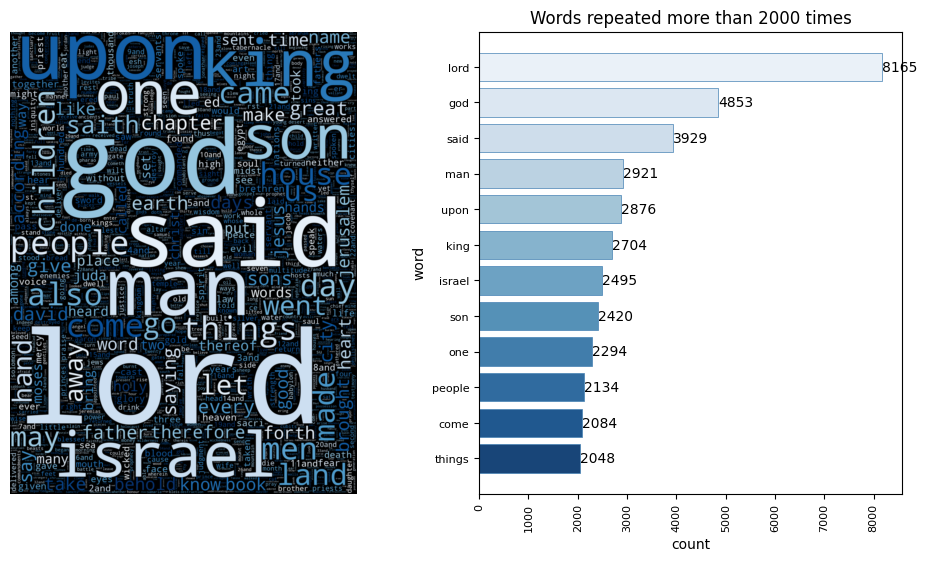

In [29]:
wordcloud_bar(file_dict, 2000, df_up2000["word"], df_up2000["count"], "Words repeated more than 2000 times", "../raw_data/cleaned_word_cloud.jpg")

📝 Let's start the data analysis 

📝 Compare the men and women names counts

In [30]:
list_most = ["jesus","david","christ", "moses", "jacob", "pharao", "joseph", "cain", "solomon", "saul", "abraham"]

In [31]:
list_women_names = ["mary", "salome","shelamzion", "martha", "priscilla", "anna", "judith", "susanna"]

[]

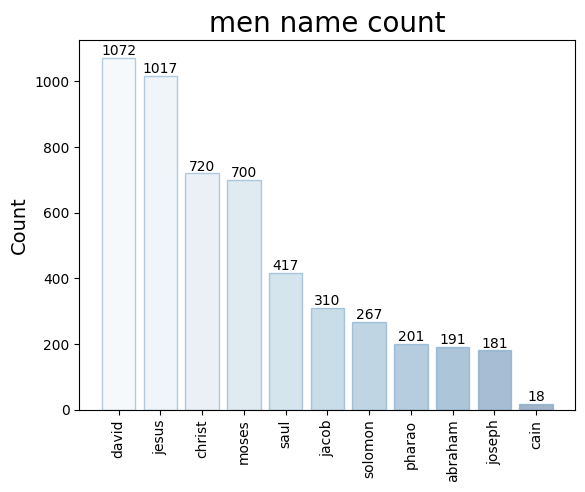

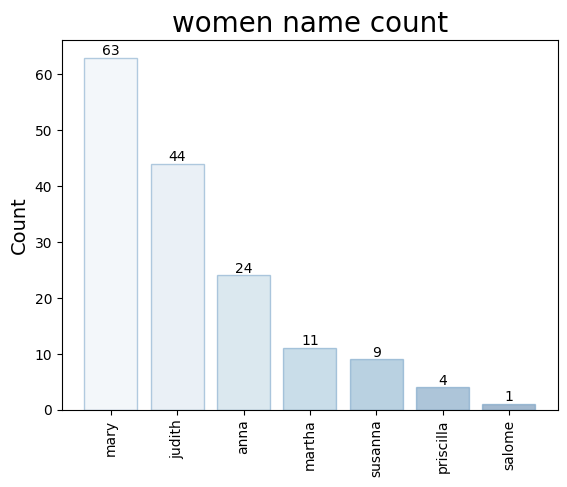

In [32]:
plot_word(df_file_new, list_most, "men name count", "bottom", None, "Count", "../raw_data/men_name_count.jpg")
plot_word(df_file_new, list_women_names, "women name count", "bottom", None, "Count", "../raw_data/women_name_count.jpg")

📝 List of the apostles names. Note that it includes not only the names of the apostle but also similar names through the bible.

In [33]:
list_apostles = ["peter", "andrew","james","john", "philip", "bartholomew", "thomas", "matthew", "levi", "simon", "matthias", "judas", "thaddeus"]

In [34]:
len(list_apostles)

13

[]

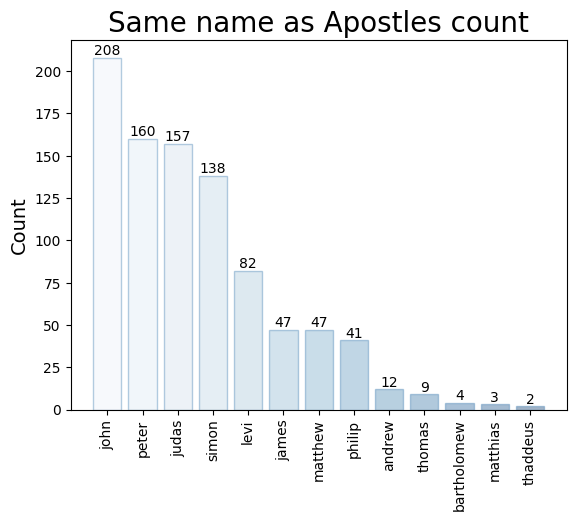

In [35]:
plot_word(df_file_new, list_apostles, "Same name as Apostles count", "bottom", None, "Count","../raw_data/Same_name _as_Apostles_count.jpg" )

📝Most common cities

In [239]:
list_cities = ["israel", "juda", "jerusalem", "egypt",
               "ammon","moab", "aram", "damascus", "samaria", "edom", "philistine", "jericho",
              "byblos", "gaza", "hebron", "macedonia", "athens", "corinth","babylon", "alexandria", "rome"]

[]

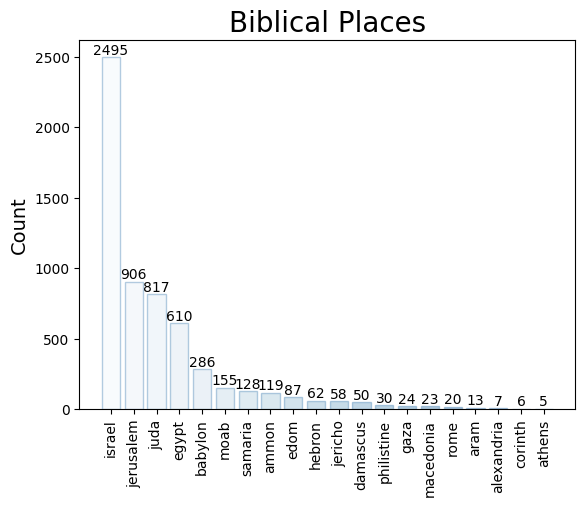

In [240]:
plot_word(df_file_new, list_cities, "Biblical Places", "bottom", None, "Count", "../raw_data/cities_count.jpg")

📝 Origin of the names and word count

In [38]:
list_names_full = ["peter", "andrew","james","john", "philip", "bartholomew", "thomas",
                   "matthew", "levi", "simon", "matthias", "judas", "thaddeus", "jesus","david", "christ",
                    "moses", "jacob", "joseph", "cain", "solomon", "saul",
                   "abraham", "mary", "salome","shelamzion", "martha", "priscilla", "anna", "judith",
                   "susanna"]

In [39]:
origin_list = ["greek", "greek","hebrew","hebrew", "greek", "aramaic", "hebrew",
               "hebrew", "hebrew", "hebrew", "hebrew", "hebrew", "uncertain", "hebrew/aramaic","hebrew",
               "hebrew", "hebrew/egypt", "hebrew", "hebrew", "hebrew", "aramaic", "hebrew",
               "hebrew", "hebrew", "hebrew","hebrew", "aramaic", "latin", "hebrew", "hebrew",
               "egyptian/persian"]

In [256]:
#create a dataframe with the two lists
df_origin_names = pd.DataFrame(zip(list_names_full, origin_list)).rename(columns={0: "word", 1:"origin"})
#extrat the words from the bible dataframe
df_names_count = df_file_new[df_file_new["word"].isin(list_names_full)]
#join the two dataframe
df_names_origin_count = df_names_count.set_index('word').join(df_origin_names.set_index('word')).reset_index().sort_values(by="count", ascending=False)

In [263]:
df_names_origin_count.head()

,word,count,origin
0,david,1072,hebrew
1,jesus,1017,hebrew/aramaic
2,christ,720,hebrew
3,moses,700,hebrew/egypt
4,saul,417,hebrew


📝 Plotting the data with this new function where this time, I needed to show the origin of the name

In [78]:
def plot_name_count_origin(df):
    fig, ax = plt.subplots()
    sns.barplot(df, x= "word", y="count", palette="Blues", edgecolor ="steelblue")
    plt.xlabel("names", size=12)
    plt.ylabel("count", size=12)

    #attribute the label to each box
    rects = ax.patches
    labels=df_names_origin_count["origin"]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom", rotation=90
        )
    plt.xticks(rotation=90)
    plt.savefig("../raw_data/name_count_origin.jpg", bbox_inches='tight')
    return plt.show()

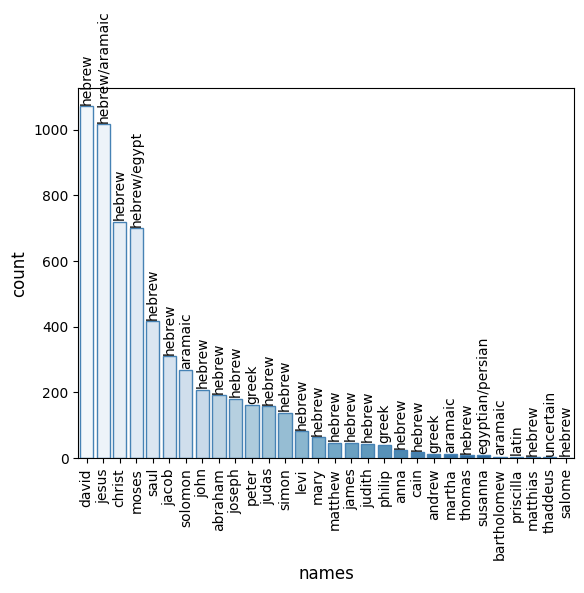

In [79]:
plot_name_count_origin(df_names_origin_count)

# Bible New International version

This bible is the protestant version

In [107]:
file_name_niv= '../raw_data/NIV-Bible-PDF.pdf'
file_niv = open(file_name_niv,'rb')
text_niv = read_pdf(file_niv)

Xref table not zero-indexed. ID numbers for objects will be corrected.


In [241]:
keywords_niv = tokenize_word_text(text_niv)
file_dict_niv = word_count(keywords_niv)
df_file_new_niv = new_file(file_dict_niv)

In [242]:
df_file_new_niv.describe()

,count
count,23222.000000
mean,14.821290
std,91.846083
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,7773.000000


📝 Count the number of words

In [243]:
df_file_new_niv["count"].sum()

344180

In [266]:
#filter the words repeated more than 2000 times
df_up2000_niv = df_file_new_niv.query("count >2000").reset_index()
df_up2000_niv.head()

,index,word,count
0,16044,lord,7773
1,13511,god,4079
2,19549,said,3179
3,15517,king,2460
4,17360,one,2362


[]

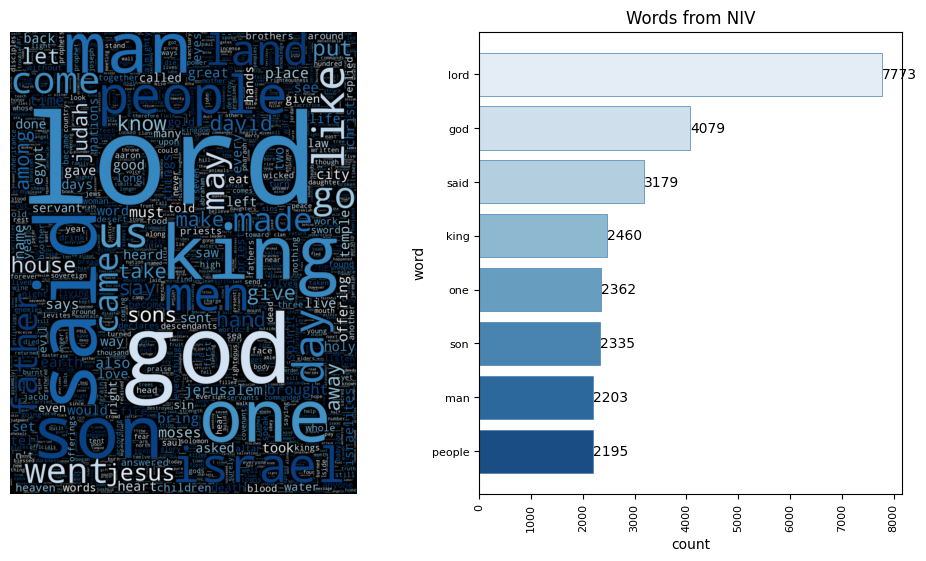

In [250]:
wordcloud_bar(file_dict_niv, 2000, df_up2000_niv["word"], df_up2000_niv["count"], "Words from NIV", "../raw_data/cleaned_word_cloud_niv.jpg")

In [257]:
df_names_count_niv = df_file_new_niv[df_file_new_niv["word"].isin(list_names_full)]
#df_names_count_niv

In [251]:
#join the two dataframe
df_niv_vs_kj =df_names_count_niv.set_index('word').join(df_names_count.set_index('word'), how='left',lsuffix='_left', rsuffix='_right').reset_index().rename(columns={"count_left":"count_NIV", "count_right":"count_DR"})

In [258]:
# do the difference between the 2 columns
df_niv_vs_kj["diff_count"] = df_niv_vs_kj["count_NIV"]-df_niv_vs_kj["count_DR"]

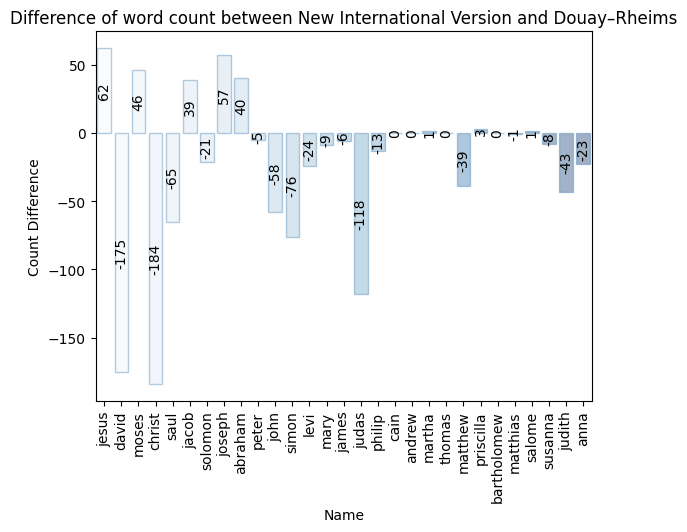

In [253]:
fig, ax = plt.subplots()
sns.barplot(df_niv_vs_kj, x="word", y="diff_count", palette = "Blues", edgecolor ="steelblue", alpha=0.4)
for i in ax.containers:
    ax.bar_label(i, rotation=90, label_type='center', color="black")
ax.set_title("Difference of word count between New International Version and Douay–Rheims")
plt.xticks(rotation=90)
plt.xlabel("Name")
plt.ylabel("Count Difference")
plt.savefig("../raw_data/diff_count.jpg",bbox_inches="tight");